# RAG Decoder

## 1. Retrieval

In [1]:
import matplotlib.pyplot as plt
from alignment import *
from utils import *

/Users/rishabhrao/Documents/VSCode/multimodal-3d-gen/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"

In [3]:
df = pd.read_csv(dataset_path)

In [4]:
row = df.iloc[0]

mesh_id = row['fullId']
text = row['template1_desc']
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_id}/view0.png'
image = Image.open(img_path).convert('RGB')
pc_path = f'Data/ProcessedData/PointClouds/{mesh_id}.npy'
pc = torch.from_numpy(np.load(pc_path))

In [6]:
enc = EncodeUserInput(align_path="TrainedModels/ALIGN/Baseline/150.pth", align_embd=400)
cmr = CrossModalRetrival(dataset_path, embed_path)

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
ALIGN Model Loaded Successfully!


In [7]:
text_proj = enc.get_projection(text, "text")
img_proj = enc.get_projection(image, "img")
pc_proj = enc.get_projection(pc, "pc")

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
print(idx, mesh_ids)
idx, mesh_ids, arrays = cmr.retrieve(img_proj, "img", "text", top_k=5)
print(df.iloc[idx[2]]['template1_desc'])

[0, 9, 2, 1, 45] 0       9a9508597dee231d4e205745311c3a
9     3d15f0b93dc94909ce92f6b720939174
2     6de307ddb4317eae1c816f27d2a33b03
1     71f6598d5426fb34c33dcf45f2780ed8
45    5334cfe15f80099f15ac67104577aee7
Name: fullId, dtype: object
A memorex flash drive which is commonly known as <no_tags>. It is associated with the following characteristics: memory device,storage device.
A general description of this item is: a device that preserves information for retrieval.


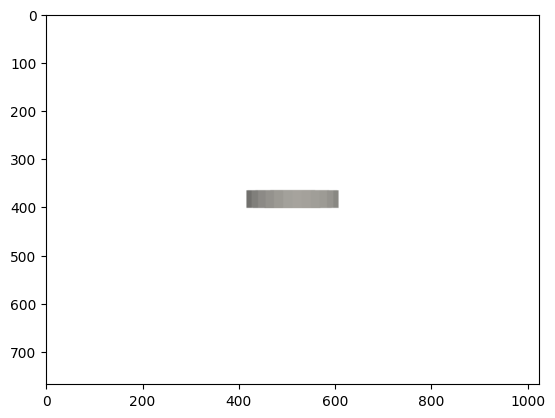

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view0.png'
img = plt.imread(img_path)
plt.imshow(img)

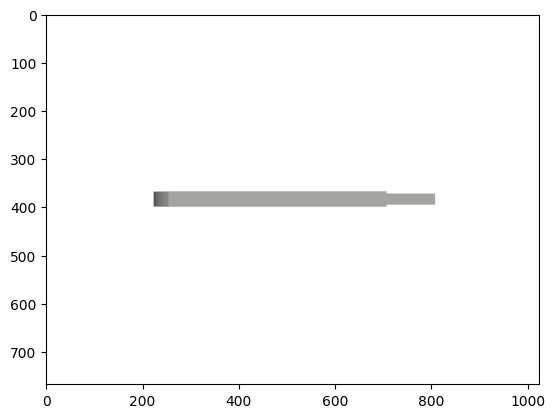

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(pc_proj, "pc", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view1.png'
img = plt.imread(img_path)
plt.imshow(img)

## RAG Decoder

In [1]:
import matplotlib.pyplot as plt
from alignment import *
from utils import *
from dataset import *
from rag import *

/Users/rishabhrao/Documents/VSCode/multimodal-3d-gen/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create 3D scatter plots for predicted and actual point clouds
def plot_pc(ref_pc):
    predicted_scatter = go.Scatter3d(
        x=ref_pc[:, 0],
        y=ref_pc[:, 1],
        z=ref_pc[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue'),
        name="Predicted"
    )

    # Create the subplots: 1 row, 2 columns
    fig = make_subplots(
        rows=1, cols=1,
        subplot_titles=("Predicted Point Cloud"),
        specs=[[{'type': 'scatter3d'}]]
    )

    # Add the scatter plots to the subplots
    fig.add_trace(predicted_scatter, row=1, col=1)

    # Update layout with axis titles and a main title
    fig.update_layout(
        title=f"Predicted",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        showlegend=True
    )

    # Show the figure in an interactive window
    fig.show()

def get_plot(ref_pc):
    predicted_scatter = go.Scatter3d(
        x=ref_pc[:, 0],
        y=ref_pc[:, 1],
        z=ref_pc[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue'),
        name="Predicted"
    )

    # Create the subplots: 1 row, 2 columns
    fig = make_subplots(
        rows=1, cols=1,
        subplot_titles=("Predicted Point Cloud"),
        specs=[[{'type': 'scatter3d'}]]
    )

    # Add the scatter plots to the subplots
    fig.add_trace(predicted_scatter, row=1, col=1)

    # Update layout with axis titles and a main title
    fig.update_layout(
        title=f"Predicted",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z"
        ),
        showlegend=True
    )

    return fig

In [3]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_rag.pt"
pc_dir = "Data/ProcessedData/PointClouds/"
align_path = "TrainedModels/ALIGN/Baseline/150.pth"
rag_path = "TrainedModels/RAG/four_hidden/1500.pth"

In [4]:
data_dict = torch.load(embed_path)

In [5]:
df = pd.read_csv(dataset_path)

In [6]:
dataset = RAGDataset(data_dict, dataset_path, pc_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [7]:
for batch in dataloader:
    idx = batch['index'].item()
    category = batch['category']
    pc = batch['target_pc']
    print(df.loc[idx, 'category'], category)
    plot_pc(pc.squeeze(0))
    break

ChestOfDrawers,Nightstand ['ChestOfDrawers,Nightstand']


In [8]:
df.head()

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
0,9a9508597dee231d4e205745311c3a,USBStick,usb memory stick sketchyphysics,"computer,drive,flash,memory,port,sketchyphysic...","['memory device,storage device']",['a device that preserves information for retr...,A usb memory stick sketchyphysics which is c...,The usb memory stick sketchyphysics is a mem...,usb memory stick sketchyphysics is a memory ...
1,71f6598d5426fb34c33dcf45f2780ed8,USBStick,red usb,NaN,"['memory device,storage device']",['a device that preserves information for retr...,A red usb which is commonly known as <no_tag...,"The red usb is a memory device,storage devic...","red usb is a memory device,storage device de..."
2,6de307ddb4317eae1c816f27d2a33b03,USBStick,cig usb drive,"cig,cigarette,flash drive,smoke,thumb drive,us...","['memory device,storage device']",['a device that preserves information for retr...,A cig usb drive which is commonly known as cig...,"The cig usb drive is a memory device,storage d...","cig usb drive is a memory device,storage devic..."
3,ab82d56cf9cc2476d154e1b098031d39,USBStick,mp,"music,usb item","['memory device,storage device']",['a device that preserves information for retr...,"A mp which is commonly known as music,usb item...","The mp is a memory device,storage device often...","mp is a memory device,storage device designed ..."
4,353fe70ec5633fc5e05878fff8971272,USBStick,usb drive,NaN,"['memory device,storage device']",['a device that preserves information for retr...,A usb drive which is commonly known as <no_tag...,"The usb drive is a memory device,storage devic...","usb drive is a memory device,storage device de..."


In [9]:
enc = EncodeUserInput(align_path=align_path, align_embd=400)
cmr = CrossModalRetrival(dataset_path, embed_path)

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
ALIGN Model Loaded Successfully!


In [10]:
prompt = "automative vehicle used for hauling"

In [11]:
rag_decoder = load_rag(rag_path)

In [12]:
fig = generate_pc_from_user_prompt(pc_dir, prompt, 'text', enc, cmr, rag_decoder)
fig.show()

In [22]:
projection, ref_pc = get_aligned_pc_from_user_prompt(pc_dir, prompt, 'text', enc, cmr)

In [23]:
projection.shape, ref_pc.shape

(torch.Size([1, 400]), torch.Size([1024, 3]))

In [24]:
pc = ref_pc.view(-1)
pc = pc.unsqueeze(0)
projection.shape, pc.shape

(torch.Size([1, 400]), torch.Size([1, 3072]))

In [25]:
combined_input = torch.concat((projection, pc), dim=1)
combined_input.shape

torch.Size([1, 3472])

In [26]:
num_points = 1024  # Number of points in the point cloud
in_dim = 400 + num_points * 3  # Input dimension (projection + flattened point cloud)
hidden_dim = 512  # Hidden layer size
out_dim = num_points * 3
num_hidden_layers = 4
rag_path = "TrainedModels/RAG/four_hidden/500.pth"
rag_decoder = RAGDecoder(in_dim, hidden_dim, out_dim, num_hidden_layers=4)
state_dict = torch.load(rag_path, map_location=torch.device('cpu'))  # Load to CPU
# Apply the weights to the model
rag_decoder.load_state_dict(state_dict)
# Set to evaluation mode (if needed)
device = "cuda" if torch.cuda.is_available() else "cpu"
rag_decoder.to(device)
print("Success")

Success


In [27]:
with torch.no_grad():
    pred_pc = rag_decoder(combined_input.to(dtype=torch.float32))
pred_pc.shape

torch.Size([1, 1024, 3])

In [28]:
pred_pc = pred_pc.squeeze(0)
pred_pc.shape

torch.Size([1024, 3])

In [29]:

# Create 3D scatter plots for predicted and actual point clouds
predicted_scatter = go.Scatter3d(
    x=ref_pc[:, 0],
    y=ref_pc[:, 1],
    z=ref_pc[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name="Predicted"
)

# Create the subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=1,
    subplot_titles=("Predicted Point Cloud"),
    specs=[[{'type': 'scatter3d'}]]
)

# Add the scatter plots to the subplots
fig.add_trace(predicted_scatter, row=1, col=1)

# Update layout with axis titles and a main title
fig.update_layout(
    title=f"Predicted",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    showlegend=True
)

# Show the figure in an interactive window
fig.show()


In [97]:
import random

In [48]:
dataset = RAGDataset(data_dict, dataset_path, pc_dir)

batch_size = 8
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
modality_choices = ['text', 'img', 'pc']
# Iterate through the DataLoader
for batch in dataloader:
    point_clouds = []
    projections = []
    for i in range(batch_size):
        # idx, text_proj, img_proj, pc_proj, category = batch['index'][i], batch['text_proj'][i], batch['img_proj'][i], batch['pc_proj'][i], batch['category'][i]
        # print(idx, text_proj.shape, img_proj.shape, pc_proj.shape, category)

        # Choose one random projection to use
        choice = random.choice(modality_choices)
        projection = batch[f"{choice}_proj"][i]
        pc = get_aligned_pc_from_projection(pc_dir, projection, choice, cmr)
        # print(pc.shape)
        projections.append(projection)
        point_clouds.append(pc)

    point_clouds = torch.stack(point_clouds) # (B, num_points, 3)
    projections = torch.stack(projections) # (B, 1, 400)
    point_clouds = point_clouds.view(batch_size, -1)
    projections = projections.squeeze(1)
    print(point_clouds.shape, projections.shape)
    break

torch.Size([8, 3072]) torch.Size([8, 400])


In [49]:
import torch.nn as nn

In [50]:
class HiddenLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
    
    def forward(self, x):
        x = self.fc(x)
        x = torch.relu(x)
        return x
    
class RAGDecoder(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_hidden_layers=1, num_points=1024):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Sequential(*[HiddenLayer(hidden_dim) for i in range(num_hidden_layers)])
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        self.num_points = num_points
        self.relu = nn.ReLU
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x.view(-1, self.num_points, 3)

def chamfer_distance(pc1, pc2):
    """
    Chamfer Distance between two point clouds.
    pc1 and pc2 should be of shape (B, N, 3).
    """
    pc1 = pc1.unsqueeze(2)  # Expand to (B, N, 3, 1)
    pc2 = pc2.unsqueeze(1)  # Expand to (B, 1, N, 3)
    
    dist = torch.norm(pc1 - pc2, dim=3)  # Calculate the L2 distance between points
    min_dist1 = dist.min(dim=2)[0]  # Min distance along the second axis
    min_dist2 = dist.min(dim=1)[0]  # Min distance along the first axis
    
    # Return the mean Chamfer Distance
    return min_dist1.mean() + min_dist2.mean()

### Training Code

In [14]:
dataset = RAGDataset(data_dict, dataset_path, pc_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

B = 8  # Batch size
num_points = 1024  # Number of points in the point cloud
in_dim = 400 + num_points * 3  # Input dimension (projection + flattened point cloud)
hidden_dim = 512  # Hidden layer size
out_dim = num_points * 3  # Output dimension (for point cloud with 3 coordinates per point)
modality_choices = ['text', 'img', 'pc']

rag_decoder = RAGDecoder(in_dim, hidden_dim, out_dim)
optimizer = torch.optim.Adam(rag_decoder.parameters(), lr=1e-4)

# Iterate through the DataLoader

for batch in dataloader:
    point_clouds = []
    projections = []
    target_point_clouds = batch['target_pc'].to(dtype=torch.float32)
    for i in range(batch_size):
        # idx, text_proj, img_proj, pc_proj, category = batch['index'][i], batch['text_proj'][i], batch['img_proj'][i], batch['pc_proj'][i], batch['category'][i]
        # print(idx, text_proj.shape, img_proj.shape, pc_proj.shape, category)

        # Choose one random projection to use
        choice = random.choice(modality_choices)
        projection = batch[f"{choice}_proj"][i]
        pc = get_aligned_pc_from_projection(pc_dir, projection, choice, cmr)
        # print(pc.shape)
        projections.append(projection)
        point_clouds.append(pc)

    point_clouds = torch.stack(point_clouds) # (B, num_points, 3)
    projections = torch.stack(projections) # (B, 1, 400)
    print(point_clouds.shape, projections.shape)
    point_clouds = point_clouds.view(batch_size, -1)
    projections = projections.squeeze(1)
    print(point_clouds.shape, projections.shape)
    combined_input = torch.concat((projections, point_clouds), dim=1)
    combined_input = combined_input.to(dtype=torch.float32)
    print(combined_input.shape)
    pred_point_clouds = rag_decoder(combined_input)
    loss = chamfer_distance(pred_point_clouds, target_point_clouds)

    print(f"Point Cloud Input Shape: {point_clouds.shape}, Projections Shape: {projections.shape}")
    print(f"Combined Input Shape: {combined_input.shape}")
    print(f"Predicted Input Shape: {pred_point_clouds.shape}, Target Shape: {target_point_clouds.shape}")
    print(f"Loss: {loss}, {type(loss)}")

    optimizer.zero_grad()
    loss.backward()

    #"""
    for param in rag_decoder.parameters():
        if param.grad is None:
            print(f"Gradient is None for parameter: {param}")
        else:
            print(f"Gradient for has shape {param.grad.shape}")
    
    #"""
    
    optimizer.step()
    break

torch.Size([8, 1024, 3]) torch.Size([8, 1, 400])
torch.Size([8, 3072]) torch.Size([8, 400])
torch.Size([8, 3472])
Point Cloud Input Shape: torch.Size([8, 3072]), Projections Shape: torch.Size([8, 400])
Combined Input Shape: torch.Size([8, 3472])
Predicted Input Shape: torch.Size([8, 1024, 3]), Target Shape: torch.Size([8, 1024, 3])
Loss: 0.7332887649536133, <class 'torch.Tensor'>
Gradient for has shape torch.Size([512, 3472])
Gradient for has shape torch.Size([512])
Gradient for has shape torch.Size([512, 512])
Gradient for has shape torch.Size([512])
Gradient for has shape torch.Size([3072, 512])
Gradient for has shape torch.Size([3072])


### Using model

In [18]:
import matplotlib.pyplot as plt
from alignment import *
from utils import *
from rag import *
from dataset import *
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"
pc_dir = "Data/ProcessedData/PointClouds/"
num_points = 1024  # Number of points in the point cloud
in_dim = 400 + num_points * 3  # Input dimension (projection + flattened point cloud)
hidden_dim = 512  # Hidden layer size
out_dim = num_points * 3 

In [58]:
rag_decoder = RAGDecoder(in_dim, hidden_dim, out_dim, num_hidden_layers=1)  # Ensure the architecture matches

# Load the saved weights
checkpoint_path = "TrainedModels/RAG/Baseline/999.pth"
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Load to CPU
rag_decoder.load_state_dict(state_dict)
# Set to evaluation mode (if needed)
device = "cuda" if torch.cuda.is_available() else "cpu"
rag_decoder.to(device)

RAGDecoder(
  (fc1): Linear(in_features=3472, out_features=512, bias=True)
  (fc2): Sequential(
    (0): HiddenLayer(
      (fc): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (fc3): Linear(in_features=512, out_features=3072, bias=True)
)

In [59]:
batch_size = 8
cmr = CrossModalRetrival(dataset_path, embed_path)

data_dict = torch.load(embed_path)
dataset = RAGDataset(data_dict, dataset_path, pc_dir)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

modality_choices = ['text', 'img', 'pc']

In [60]:
with torch.no_grad():
    for batch in dataloader:
        point_clouds = []
        projections = []
        target_point_clouds = batch['target_pc'].to(dtype=torch.float32)
        categories = []
        for i in range(batch_size):
            # idx, text_proj, img_proj, pc_proj, category = batch['index'][i], batch['text_proj'][i], batch['img_proj'][i], batch['pc_proj'][i], batch['category'][i]
            # print(idx, text_proj.shape, img_proj.shape, pc_proj.shape, category)
            categories.append(batch['category'][i])
            # Choose one random projection to use
            choice = random.choice(modality_choices)
            projection = batch[f"{choice}_proj"][i]
            pc = get_aligned_pc_from_projection(pc_dir, projection, choice, cmr)
            # print(pc.shape)
            projections.append(projection)
            point_clouds.append(pc)

        point_clouds = torch.stack(point_clouds) # (B, num_points, 3)
        projections = torch.stack(projections) # (B, 1, 400)
        point_clouds = point_clouds.view(batch_size, -1)
        projections = projections.squeeze(1)
        print(f"Point Cloud Input Shape: {point_clouds.shape}, Projections Shape: {projections.shape}")
        
        combined_input = torch.concat((projections, point_clouds), dim=1)
        combined_input = combined_input.to(dtype=torch.float32)
        pred_point_clouds = rag_decoder(combined_input)
        loss = chamfer_distance(pred_point_clouds, target_point_clouds)
        #"""
        print(f"Point Cloud Input Shape: {point_clouds.shape}, Projections Shape: {projections.shape}")
        print(f"Combined Input Shape: {combined_input.shape}")
        print(f"Predicted Input Shape: {pred_point_clouds.shape}, Target Shape: {target_point_clouds.shape}")
        print(f"Loss: {loss}, {type(loss)}")
        #"""
        break

Point Cloud Input Shape: torch.Size([8, 3072]), Projections Shape: torch.Size([8, 400])
Point Cloud Input Shape: torch.Size([8, 3072]), Projections Shape: torch.Size([8, 400])
Combined Input Shape: torch.Size([8, 3472])
Predicted Input Shape: torch.Size([8, 1024, 3]), Target Shape: torch.Size([8, 1024, 3])
Loss: 0.418423593044281, <class 'torch.Tensor'>


In [61]:
pred_point_clouds.shape, target_point_clouds.shape, categories

(torch.Size([8, 1024, 3]),
 torch.Size([8, 1024, 3]),
 ['Table,CoffeeTable',
  'Table,DiningTable,_AttributesTrain',
  'Table,DiningTable,_StanfordSceneDBModels,RoundTable',
  '_StanfordSceneDBModels,PillBottle',
  'DrinkingUtensil,WineGlass',
  'Table,EndTable,_StanfordSceneDBModels,RoundTable',
  'PersonStanding',
  'ChestOfDrawers,Nightstand'])

In [65]:
num = random.choice(list(range(0, batch_size)))
predicted_point_cloud = pred_point_clouds[num].numpy()
actual_point_cloud = target_point_clouds[num].numpy()

# Create 3D scatter plots for predicted and actual point clouds
predicted_scatter = go.Scatter3d(
    x=predicted_point_cloud[:, 0],
    y=predicted_point_cloud[:, 1],
    z=predicted_point_cloud[:, 2],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name="Predicted"
)

actual_scatter = go.Scatter3d(
    x=actual_point_cloud[:, 0],
    y=actual_point_cloud[:, 1],
    z=actual_point_cloud[:, 2],
    mode='markers',
    marker=dict(size=5, color='red'),
    name="Actual"
)

# Create the subplots: 1 row, 2 columns
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Predicted Point Cloud", "Actual Point Cloud"),
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]]
)

# Add the scatter plots to the subplots
fig.add_trace(predicted_scatter, row=1, col=1)
fig.add_trace(actual_scatter, row=1, col=2)

# Update layout with axis titles and a main title
fig.update_layout(
    title=f"Predicted vs Actual Point Clouds {categories[0]}",
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    scene2=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    showlegend=True
)

# Show the figure in an interactive window
fig.show()


In [27]:
# check to make sure dataloader of RAG is loading in the correct projections only and that the category is right check using cmr

## User Input

In [5]:
from alignment import *
from rag import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"
pc_dir = "Data/ProcessedData/PointClouds/"
align_path = "TrainedModels/ALIGN/Baseline/150.pth"
rag_path = "TrainedModels/RAG/four_hidden/1500.pth"

cmr = CrossModalRetrival(dataset_path, embed_path)
data_dict = torch.load(embed_path)
enc = EncodeUserInput(align_path="TrainedModels/ALIGN/Baseline/150.pth")
rag_decoder = load_rag(rag_path)

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
ALIGN Model Loaded Successfully!
RAG Model Loaded succesfully!


In [24]:
prompt = "glass"
generate_rag_output_website(pc_dir, prompt, 'text', enc, cmr, rag_decoder)

torch.Size([1, 400]) torch.Size([1024, 3])
torch.Size([1, 400]) torch.Size([1, 3072])
torch.Size([1, 3472])
